In [16]:
import os
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn

In [17]:
assert torch.cuda.is_available(), 'CUDA is not correctly installed!!'
print(torch.tensor([2.0, 3.0, 1.0]).cuda())
property = torch.cuda.get_device_properties(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tensor([2., 3., 1.], device='cuda:0')


In [18]:
print('====== Your GPU info ======')
print('name:\t\t', property.name)
print('capability:\t', 'v{}.{}'.format(property.major, property.minor))
print('memory:\t\t', round(property.total_memory / 1e9), 'Gb')
print('processors:\t', property.multi_processor_count)

====== Your GPU info ======
name:		 Tesla T4
capability:	 v7.5
memory:		 16 Gb
processors:	 40


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# LOAD DATASET HERE

# Load headers
csv_path = "dataset_v2.csv"

with open(csv_path, 'r', newline='') as csv_fh:
    headers = csv_fh.readline().strip().split(',')
    
    
label_col = "Price"
date_col = "Date(UTC)"
# Load features and labels
x_cols = [i for i in range(len(headers)) if (headers[i] != date_col)]
l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
prices = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)


# Label regularization
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices.reshape(-1,1))
# # add intercept
new_x = np.zeros((inputs.shape[0], inputs.shape[1] + 1), dtype=inputs.dtype)
new_x[:, 0] = 1
new_x[:, 1:] = inputs

inputs = new_x
# Feature engineering
norm = MinMaxScaler().fit(inputs)
inputs = norm.transform(inputs)

# apply standardization on numerical features
for i in range(inputs.shape[1]):
    
    # fit on training data column
    scale = StandardScaler().fit(inputs[[i]])
    
    # transform the training data column
    inputs[i] = scale.transform(inputs[[i]])


print(inputs.shape)



(2463, 17)


In [20]:
# split a multivariate sequence into samples
def split_sequences(sequences, labels, n_steps, test_size=0.2):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        
        seq_x, seq_y = sequences[i:end_ix, :], labels[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    X = np.array(X)
    y = np.array(y)
    
    test_set_size = int(np.round(test_size * X.shape[0]))
    train_set_size = X.shape[0] - (test_set_size)
    
    X_train = X[:train_set_size,:-1,:]
    y_train = y[:train_set_size]
    
    X_test = X[train_set_size:,:-1,:]
    y_test = y[train_set_size:]
    
    return [X_train, y_train, X_test, y_test]

In [21]:
def split_data(stock, lookback):
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [22]:
# ----------------- Split Dataset -----------------

lookback = 10
test_size = 0.2  # percentage of the dataset split to test data
X_train, y_train, X_test, y_test = split_sequences(inputs, prices, lookback, test_size)


print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (1963, 9, 17)
y_train.shape =  (1963, 1)
X_test.shape =  (491, 9, 17)
y_test.shape =  (491, 1)


In [23]:
# Convert data to tensors, move onto GPU
X_train, X_test = torch.Tensor(X_train).to(device), torch.Tensor(X_test).to(device)
y_train, y_test = torch.Tensor(y_train).to(device), torch.Tensor(y_test).to(device)

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [25]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
# hyper params

input_dim = X_train.shape[2] # num features
hidden_dim = 48
num_layers = 1  # num lstm layers (was 2)

epochs = 2000
learning_rate = 0.001


# model = MV_LSTM(lookback=lookback, input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
# model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=1).to(device)
criterion = torch.nn.MSELoss()  # remove the reduction if it doesn't work
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [27]:
# ----------------- TRAIN ------------------
losses = []
losses_test = []
acc = []
acc_test =[]
iter = 0
step = 200
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    # calculate loss on the train dataset
    losses.append(loss.item())
    
    with torch.no_grad():
        # Calculating the loss test dataset
        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)
        losses_test.append(loss_test.item())
        
    
    # Print out benchmarking
    if iter%step==0:
        print(f"Iteration: {iter}. \nTrain -  Loss: {loss.item()}.\n")
        print(f"Test - Loss: {loss_test.item()}.")
        
        
    iter+=1

Training Epochs:   3%|▌                      | 54/2000 [00:00<00:07, 267.88it/s]

Iteration: 0. 
Train -  Loss: 0.02283625118434429.

Test - Loss: 0.40139657258987427.


Training Epochs:  14%|██▉                   | 271/2000 [00:00<00:04, 363.06it/s]

Iteration: 200. 
Train -  Loss: 0.00011310985428281128.

Test - Loss: 0.1350521743297577.


Training Epochs:  23%|█████                 | 461/2000 [00:01<00:04, 372.78it/s]

Iteration: 400. 
Train -  Loss: 5.0251121137989685e-05.

Test - Loss: 0.056517764925956726.


Training Epochs:  33%|███████▏              | 654/2000 [00:01<00:03, 379.86it/s]

Iteration: 600. 
Train -  Loss: 2.953243711090181e-05.

Test - Loss: 0.020166080445051193.


Training Epochs:  42%|█████████▎            | 845/2000 [00:02<00:03, 380.32it/s]

Iteration: 800. 
Train -  Loss: 2.3265765776159242e-05.

Test - Loss: 0.010506263002753258.


Training Epochs:  54%|███████████▎         | 1075/2000 [00:02<00:02, 378.39it/s]

Iteration: 1000. 
Train -  Loss: 1.9966908439528197e-05.

Test - Loss: 0.006795977707952261.


Training Epochs:  63%|█████████████▎       | 1266/2000 [00:03<00:01, 377.99it/s]

Iteration: 1200. 
Train -  Loss: 1.790244823496323e-05.

Test - Loss: 0.005483782850205898.


Training Epochs:  73%|███████████████▎     | 1459/2000 [00:03<00:01, 381.74it/s]

Iteration: 1400. 
Train -  Loss: 1.6441419575130567e-05.

Test - Loss: 0.0052523184567689896.


Training Epochs:  83%|█████████████████▎   | 1653/2000 [00:04<00:00, 381.12it/s]

Iteration: 1600. 
Train -  Loss: 1.536676245450508e-05.

Test - Loss: 0.005646490026265383.


Training Epochs:  92%|███████████████████▍ | 1848/2000 [00:04<00:00, 378.38it/s]

Iteration: 1800. 
Train -  Loss: 1.4626201846112963e-05.

Test - Loss: 0.006364376749843359.


Training Epochs: 100%|█████████████████████| 2000/2000 [00:05<00:00, 371.47it/s]


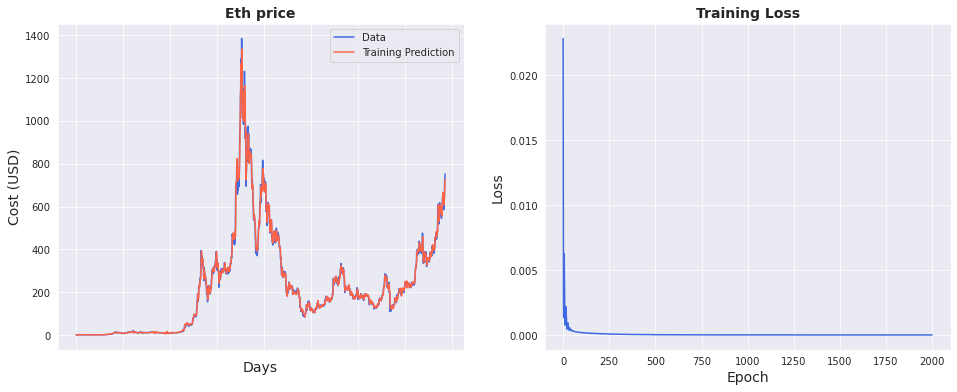

In [28]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")    

predict = pd.DataFrame(scaler.inverse_transform(outputs.cpu().detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.cpu().detach().numpy()))

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction", color='tomato')
ax.set_title('Eth price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=losses, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

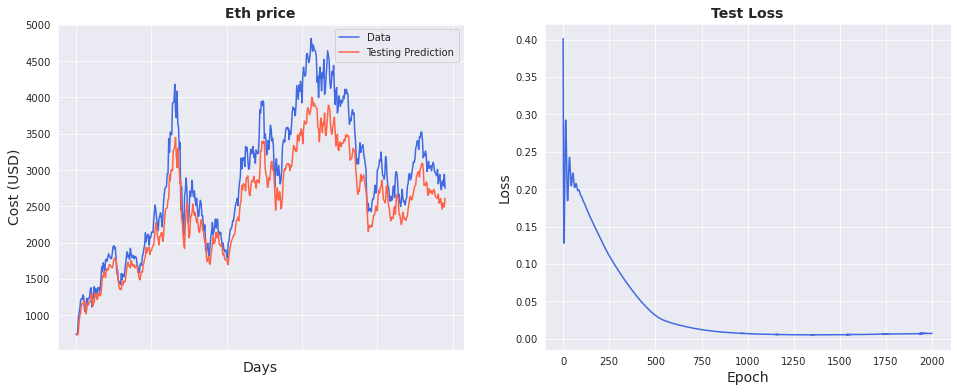

In [29]:
sns.set_style("darkgrid")    

predict = pd.DataFrame(scaler.inverse_transform(outputs_test.cpu().detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_test.cpu().detach().numpy()))

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Testing Prediction", color='tomato')
ax.set_title('Eth price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=losses_test, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Test Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [30]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(y_train.cpu().detach().numpy(), outputs.cpu().detach().numpy()))
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test.cpu().detach().numpy(), outputs_test.cpu().detach().numpy()))
print('Test Score: %.6f RMSE' % (testScore))

Train Score: 0.003763 RMSE
Test Score: 0.084210 RMSE
